In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset, DatasetPreprocessor
from experimentsv2 import (
    train_model,
    train_B,
    base_counterfactual_generate,
    prepare_base_counterfactual_explainer,
    robust_counterfactual_generate,
)


In [ ]:
dataset = Dataset("moons")
dataset_preprocessor = DatasetPreprocessor(
    dataset=dataset,
    random_state=1,
    one_hot=True,
)

In [ ]:
X_train_pd, X_test_pd, y_train, y_test = dataset_preprocessor.get_data()
X_train, X_test = [x.to_numpy() for x in (X_train_pd, X_test_pd)]

In [ ]:
hparams = {
    "loss": "BCELoss",
    "early_stopping": True,
    "lr": 0.001,
    "epochs": 100,
    "batch_size": 128,
    "verbose": True,
    "dropout": 0.4,
    "classification_threshold": 0.5,
    "hidden_layers": 3,
    "neurons_per_layer": 128,
    "activation": "relu",
    "optimizer": "adam",
}
model1, pred_proba1, pred_crisp1 = train_model(
    X_train, y_train, "neural_network", 1, hparams
)

In [ ]:
modelsB = train_B(
    ex_type="Bootstrap",
    model_type_to_use="neural_network",
    model_base_hyperparameters=hparams,
    model_fixed_hparams=hparams,
    model_hyperparameters_pool={},
    model_fixed_seed=2,
    k_mlps_in_B=32,
    n_jobs=8,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
)

TypeError: train_K_mlps_in_parallel() got an unexpected keyword argument 'hparams'

In [ ]:
beta_gs_hparams = {
    "max_iter": 100,
    "n_search_samples": 100,
    "p_norm": 2,
    "step": 0.1,
    "target_proba": 0.5,
}


base_explainer = prepare_base_counterfactual_explainer(
    base_cf_method="gs",
    hparams=beta_gs_hparams,
    model=model1,
    X_train=X_train_pd,
    y_train=y_train,
    dataset_preprocessor=dataset_preprocessor,
    predict_fn_1_crisp=pred_crisp1,
)

In [ ]:
i = 60
x_test_sample = X_test[i]
y_test_sample = y_test[i]
x_test_sample_pd = pd.DataFrame(x_test_sample.reshape(1, -1), columns=X_test_pd.columns)

In [ ]:
base_cf = base_counterfactual_generate(
    base_explainer=base_explainer,
    instance=x_test_sample_pd,
)

In [ ]:
target_class = 1 - pred_crisp1(x_test_sample)[0]
modelsB_crisp_fns = [model.predict_crisp for model in modelsB]

res = {
    "delta": [],
    "conf": [],
    "robust_counterfactual": [],
    "artifact_dict": [],
}

for delta in [0.5, 0.6, 0.7, 0.8, 0.9]:
    for conf in [0.95]:
        robust_counterfactual, artifact_dict = robust_counterfactual_generate(
            start_instance=base_cf,
            target_class=target_class,
            delta_target=delta,
            beta_confidence=conf,
            dataset=dataset,
            preprocessor=dataset_preprocessor,
            pred_fn_crisp=pred_crisp1,
            pred_fn_proba=pred_proba1,
            estimators_crisp=modelsB_crisp_fns,
            grow_sphere_hparams=beta_gs_hparams,
            classification_threshold=0.5,
            seed=1,
        )

        res["delta"].append(delta)
        res["conf"].append(conf)
        res["robust_counterfactual"].append(robust_counterfactual)
        res["artifact_dict"].append(artifact_dict)
    print(f"delta={delta} done")

delta=0.5 done
delta=0.6 done
delta=0.7 done
delta=0.8 done
delta=0.9 done


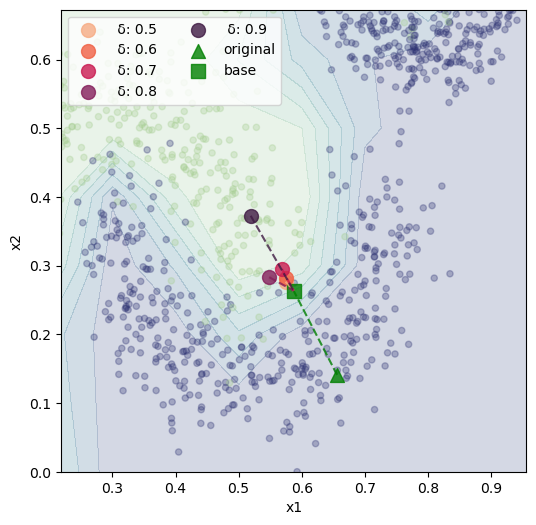

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

df = pd.DataFrame(res)
filtered_df = df[df["conf"] == 0.95].reset_index(drop=True)

cfs = filtered_df["robust_counterfactual"]


pad = 0.1
# plot the decision boundary
x_min, x_max = 0, 1.1
y_min, y_max = 0, 1.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = pred_proba1(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2, cmap="crest")
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20, alpha=0.3, cmap="crest")

area_of_interest = list()

palette = sns.color_palette("rocket_r", len(cfs))
for i, cf in enumerate(cfs):
    plt.scatter(
        cf[0],
        cf[1],
        label=f" δ: {filtered_df['delta'][i]}",
        marker="o",
        s=100,
        color=palette[i],
        alpha=0.8,
    )
    area_of_interest.append([cf[0], cf[1]])

plt.scatter(
    x_test_sample[0],
    x_test_sample[1],
    label="original",
    color="green",
    marker="^",
    s=100,
    alpha=0.8,
)
plt.scatter(
    base_cf[0], base_cf[1], label="base", color="green", marker="s", s=100, alpha=0.8
)
# Draw a line between the base and the original
plt.plot(
    [x_test_sample[0], base_cf[0]],
    [x_test_sample[1], base_cf[1]],
    color="green",
    linestyle="--",
    alpha=0.8,
)

# Draw a line between the base and the counterfactuals
for i, cf in enumerate(cfs):
    plt.plot(
        [cf[0], base_cf[0]],
        [cf[1], base_cf[1]],
        color=palette[i],
        linestyle="--",
        alpha=0.8,
    )

area_of_interest.append([x_test_sample[0], x_test_sample[1]])
area_of_interest.append([base_cf[0], base_cf[1]])

area_of_interest = np.array(area_of_interest)

aoi_pad = 0.3
xmin = max(area_of_interest[:, 0].min() - aoi_pad, 0)
xmax = min(area_of_interest[:, 0].max() + aoi_pad, 1)
ymin = max(area_of_interest[:, 1].min() - aoi_pad, 0)
ymax = min(area_of_interest[:, 1].max() + aoi_pad, 1)

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)


plt.xlabel("x1")
plt.ylabel("x2")

plt.legend(loc="upper left", ncols=2)

plt.savefig(
    "../images/paper/moons_robust_counterfactuals.png", dpi=600, bbox_inches="tight"
)

plt.show()


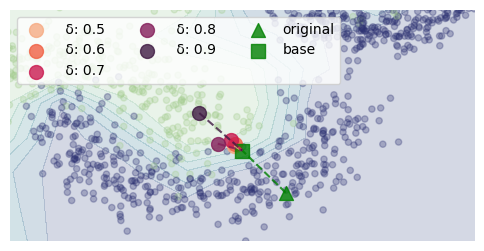

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

df = pd.DataFrame(res)
filtered_df = df[df["conf"] == 0.95].reset_index(drop=True)

cfs = filtered_df["robust_counterfactual"]


pad = 0.1
# plot the decision boundary
x_min, x_max = 0, 1.1
y_min, y_max = 0, 1.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = pred_proba1(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2, cmap="crest")
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20, alpha=0.3, cmap="crest")

area_of_interest = list()

palette = sns.color_palette("rocket_r", len(cfs))
for i, cf in enumerate(cfs):
    plt.scatter(
        cf[0],
        cf[1],
        label=f" δ: {filtered_df['delta'][i]}",
        marker="o",
        s=100,
        color=palette[i],
        alpha=0.8,
    )
    area_of_interest.append([cf[0], cf[1]])

plt.scatter(
    x_test_sample[0],
    x_test_sample[1],
    label="original",
    color="green",
    marker="^",
    s=100,
    alpha=0.8,
)
plt.scatter(
    base_cf[0], base_cf[1], label="base", color="green", marker="s", s=100, alpha=0.8
)
# Draw a line between the base and the original
plt.plot(
    [x_test_sample[0], base_cf[0]],
    [x_test_sample[1], base_cf[1]],
    color="green",
    linestyle="--",
    alpha=0.8,
)

# Draw a line between the base and the counterfactuals
for i, cf in enumerate(cfs):
    plt.plot(
        [cf[0], base_cf[0]],
        [cf[1], base_cf[1]],
        color=palette[i],
        linestyle="--",
        alpha=0.8,
    )

area_of_interest.append([x_test_sample[0], x_test_sample[1]])
area_of_interest.append([base_cf[0], base_cf[1]])

area_of_interest = np.array(area_of_interest)

aoi_pad = 0.3
xmin = max(area_of_interest[:, 0].min() - aoi_pad, 0)
xmax = min(area_of_interest[:, 0].max() + aoi_pad, 1)
ymin = max(area_of_interest[:, 1].min() - aoi_pad, 0)
ymax = min(area_of_interest[:, 1].max() + aoi_pad, 1)

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)


# Remove ticks and borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.yaxis.set_ticks_position("none")
ax.xaxis.set_ticks_position("none")
ax.yaxis.set_tick_params(width=0)
ax.xaxis.set_tick_params(width=0)
ax.set_xticks([])
ax.set_yticks([])


plt.legend(loc="upper left", ncols=3)

plt.savefig(
    "../images/paper/moons_robust_counterfactuals_clean.png",
    dpi=600,
    bbox_inches="tight",
)

plt.show()


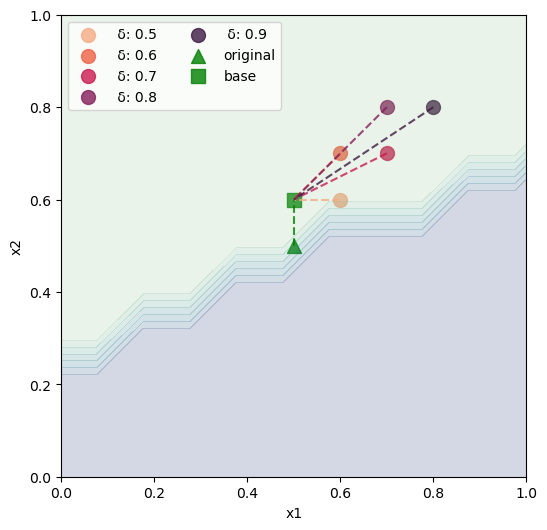

In [ ]:
import sklearn.datasets
import sklearn.linear_model
import sklearn.neighbors
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data = sklearn.datasets.make_moons(n_samples=1000, noise=0.3)

data_X, data_y = data

# Rotate data by 90 degrees
rot = np.array([[0, -1], [1, 0]])
data_X = np.dot(data_X, rot)


classifiers = []
for i in range(5, 20, 1):
    act = np.random.choice(["identity", "logistic", "tanh", "relu"])
    classifier = MLPClassifier(hidden_layer_sizes=(i, i), max_iter=1000, activation=act)
    classifier.fit(data_X, data[1])
    classifiers.append(classifier)


In [ ]:
original = [-0.5, -0.3]
base = [0.24, 0.1]
counterfactuals = [
    [0.4, 0.0],
    [0.4, 0.3],
    [0.6, 0.3],
    [0.8, 0.1],
]  # , [0.3, 0.7], [0.45, 0.7], [0.5, 0.8], [0.72, 0.84]]
deltas = [0.6, 0.7, 0.8, 0.9]

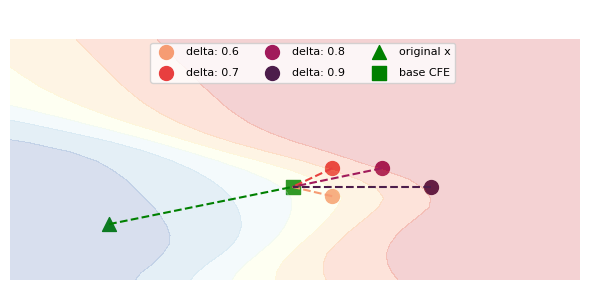

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

palette = sns.color_palette("rocket_r", len(counterfactuals))

plt.plot(
    [original[0], base[0]],
    [original[1], base[1]],
    color="green",
    linestyle="--",
    alpha=1,
)

for i, cf in enumerate(counterfactuals):
    plt.plot(
        [cf[0], base[0]], [cf[1], base[1]], color=palette[i], linestyle="--", alpha=1
    )

for i, cf in enumerate(counterfactuals):
    plt.scatter(
        cf[0],
        cf[1],
        label=f"delta: {deltas[i]}",
        marker="o",
        s=100,
        color=palette[i],
        alpha=1,
    )

plt.scatter(
    original[0],
    original[1],
    label="original x",
    color="green",
    marker="^",
    s=100,
    alpha=1,
)
plt.scatter(
    base[0], base[1], label="base CFE", color="green", marker="s", s=100, alpha=1
)


# Plot the decision boundary
x_min, x_max = data[0][:, 0].min() - 0.1, data[0][:, 0].max() + 0.1
y_min, y_max = data[0][:, 1].min() - 0.1, data[0][:, 1].max() + 0.1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[::, 1]
Z = classifiers[0].predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

for i in range(1, len(classifiers)):
    Z += classifiers[i].predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

Z = Z / len(classifiers)

Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.2, cmap="RdYlBu")
plt.xlim(-0.9, 1.4)
plt.ylim(-0.9, 2)

plt.legend(ncols=3, fontsize=8, bbox_to_anchor=(0.79, 0.9), labelspacing=1)

# Turn off the grid, ticks, and lines
plt.grid(False)
plt.tick_params(left=False, bottom=False)
plt.xticks([])
plt.yticks([])


# remove the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tight_layout()
plt.savefig(
    "../../images/paper/moons_robust_counterfactuals_clean.png",
    dpi=600,
    bbox_inches="tight",
)
plt.show()